# Exercício em Python - Tema 3 - Interpolação e Preenchimento de Falhas

Este exercício tem por objetivo avaliar a correlação entre as séries de precipitação entre algumas bacias do CABra, verificar quebras de comportamento, e preenchimento de falhas, de acordo com maiores correlações entre séries. Os exercícios estão divididos de acordo com o capítulo do Tema 3:


*   A. Correlação
*   B. Verificação da homogeneidade dos dados e correção de séries
*   C. Preenchimento de Falhas



#**A. Correlação**

## 1.Importa bibliotecas

In [ ]:
import pandas as pd
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Importação dos dados do CABra

In [ ]:
# Lista com os códigos das bacias a serem analisadas
bacias = ['420', '423', '424', '425', '427']
base1 = "ens"
base2 = "ENS"

# Dicionário para armazenar os DataFrames de cada bacia
dados_bacias = {}

# Loop para importar e preparar os dados de cada bacia
for bacia in bacias:
    url = f"https://raw.githubusercontent.com/hydrologywatersecurity/livro-python-hidrologia/refs/heads/main/CABRA_dataset/CABra_climate_daily_series/{base1}/CABra_{bacia}_climate_{base2}.txt"

    conteudo = requests.get(url).content
    df = pd.read_csv(io.StringIO(conteudo.decode('utf-8', errors='ignore')),
                     skiprows=13,
                     delimiter='\t')

    # Exclui primeira coluna depois do cabeçalho, pois contém unidades
    df = df.iloc[1:].copy()

    # Renomeia colunas
    df.columns = ['Year', 'Month', 'Day', 'p', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'pet_pm','pet_pt', 'pet_hg']

    # Converte colunas para valores numéricos
    for col in ['Year', 'Month', 'Day', 'p', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'pet_pm','pet_pt', 'pet_hg']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Cria coluna de data
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    # Seleciona apenas data e precipitação
    df = df[['date', 'p']]

    # Renomeia a coluna de precipitação para o código da bacia
    df = df.rename(columns={'p': bacia})

    # Armazena o DataFrame no dicionário
    dados_bacias[bacia] = df

# Une os dados de todas as bacias pela coluna 'date'
df_merged = dados_bacias[bacias[0]]
for bacia in bacias[1:]:
    df_merged = pd.merge(df_merged, dados_bacias[bacia], on='date', how='inner')

##3. Exclusão de valores ausentes e visualização de dados

In [ ]:
# Remove valores ausentes
df_merged = df_merged.dropna()

df_merged.head()

,date,420,423,424,425,427
0,1980-01-01,27.731,42.831,31.796,31.371,33.743
1,1980-01-02,12.499,9.581,11.381,12.488,12.525
2,1980-01-03,1.830,0.419,0.828,1.291,0.954
3,1980-01-04,0.067,0.337,0.103,0.119,0.157
4,1980-01-05,0.112,0.068,0.079,0.298,0.468


##4. Cálculo da Correlação e Plotagem dos resultados

Matriz de Correlação de Pearson:
          420       423       424       425       427
420  1.000000  0.869409  0.972493  0.990135  0.962618
423  0.869409  1.000000  0.908626  0.889407  0.887679
424  0.972493  0.908626  1.000000  0.985134  0.974844
425  0.990135  0.889407  0.985134  1.000000  0.990402
427  0.962618  0.887679  0.974844  0.990402  1.000000


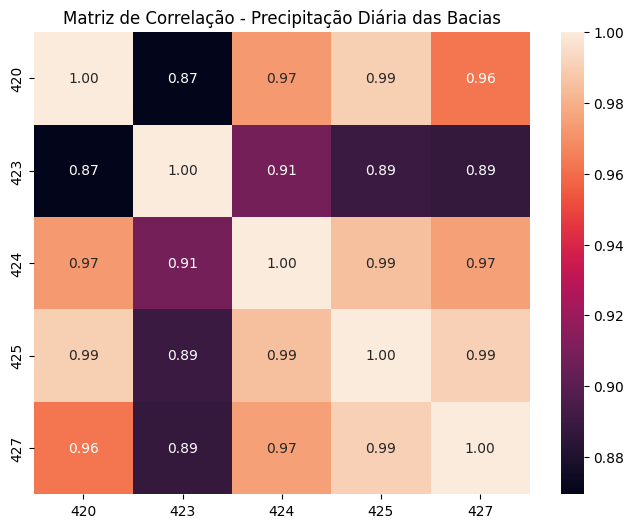


Bacia com melhor correlação com a 424: 425 (r = 0.99)


In [ ]:
# Calcula a matriz de correlação de Pearson
correlacao = df_merged[bacias].corr(method='pearson')

# Mostra a matriz
print("Matriz de Correlação de Pearson:")
print(correlacao)

# Plot da matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(correlacao, annot=True, fmt=".2f")
plt.title('Matriz de Correlação - Precipitação Diária das Bacias')
plt.show()

# Encontra a bacia com melhor correlação com a bacia 424 (excluindo ela mesma)
correlacoes_424 = correlacao['424'].drop(labels='424')
bacia_mais_correlacionada = correlacoes_424.idxmax()
valor_correlacao = correlacoes_424.max()

print(f"\nBacia com melhor correlação com a 424: {bacia_mais_correlacionada} (r = {valor_correlacao:.2f})")


#**B. Verificação da homogeneidade dos dados e correção de séries**

##1. Importação de Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from itertools import accumulate
import requests
import io

##2. Importação de dados do CABra

In [ ]:
# Lista com os códigos das bacias a serem analisadas
bacias = ['424', '422', '426', '429']
base1 = "ens"
base2 = "ENS"

# Dicionário para armazenar os DataFrames de cada bacia
dados_bacias = {}

# Loop para importar e preparar os dados de cada bacia
for bacia in bacias:
    url = f"https://raw.githubusercontent.com/hydrologywatersecurity/livro-python-hidrologia/refs/heads/main/CABRA_dataset/CABra_climate_daily_series/{base1}/CABra_{bacia}_climate_{base2}.txt"

    conteudo = requests.get(url).content
    df = pd.read_csv(io.StringIO(conteudo.decode('utf-8', errors='ignore')),
                     skiprows=13,
                     delimiter='\t')

    # Exclui primeira coluna depois do cabeçalho, pois contém unidades
    df = df.iloc[1:].copy()

    # Renomeia colunas
    df.columns = ['Year', 'Month', 'Day', 'p', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'pet_pm','pet_pt', 'pet_hg']

    # Converte colunas para valores numéricos
    for col in ['Year', 'Month', 'Day', 'p', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'pet_pm','pet_pt', 'pet_hg']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Cria coluna de data
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    # Seleciona apenas data e precipitação
    df = df[['date', 'p']]

    # Renomeia a coluna de precipitação para o código da bacia
    df = df.rename(columns={'p': bacia})

    # Armazena o DataFrame no dicionário
    dados_bacias[bacia] = df

# Une os dados de todas as bacias pela coluna 'date'
df_merged = dados_bacias[bacias[0]]
for bacia in bacias[1:]:
    df_merged = pd.merge(df_merged, dados_bacias[bacia], on='date', how='inner')

##3. Agregação dos dados por ano

In [ ]:
# df_merged com colunas: ['date', '424', '422', '426', '429']
df_merged['year'] = df_merged['date'].dt.year

# Filtra apenas as bacias desejadas
bacias_analise = ['424', '422', '426', '429']

# Soma a precipitação anual
df_anual = df_merged.groupby('year')[bacias_analise].sum().reset_index()

# Filtra o período desejado
df_anual = df_anual[df_anual['year'].between(1980, 2010)].reset_index(drop=True)

#Usar df_anual para as análises desejadas
p_424 = df_anual['424'].values
p_apoio = df_anual[['422', '426', '429']].mean(axis=1).values

##4. Acumulação dos dados e simulação de perturbação

In [ ]:
# Acumulado original
p_424_ac = list(accumulate(p_424))
p_apoio_ac = list(accumulate(p_apoio))

# Simula perturbação de +1000 mm a partir de 2000 (índice 20, ano = 2000)
p_424_changed = [v + 1000 if i >= 20 else v for i, v in enumerate(p_424)]
p_424_changed_ac = list(accumulate(p_424_changed))

##5. Determinação das equações de Regressão Linear

In [ ]:
X_total = np.array(p_apoio_ac).reshape(-1, 1)
Y_total = np.array(p_424_changed_ac)

# Divide entre antes (0:20) e depois (20:31)
X1 = X_total[:20]
Y1 = Y_total[:20]
X2 = X_total[20:]
Y2 = Y_total[20:]

reg1 = LinearRegression().fit(X1, Y1)
reg2 = LinearRegression().fit(X2, Y2)

slope_1 = reg1.coef_[0]
slope_2 = reg2.coef_[0]

K = slope_1 / slope_2
print(f"Coeficientes angulares:\n  Antes de 2000: {slope_1:.4f}\n  Depois de 2000: {slope_2:.4f}")
print(f"Constante de proporcionalidade K = {K:.4f}")

Coeficientes angulares:
  Antes de 2000: 1.0633
  Depois de 2000: 1.6972
Constante de proporcionalidade K = 0.6265


##6. Correção dos valores de precipitação da estação 424

In [ ]:
# Corrige apenas os dados até 1999 (índices < 20)
p_424_fixed = [val * K if i < 20 else val for i, val in enumerate(p_424_changed)]
p_424_fixed_ac = list(accumulate(p_424_fixed))

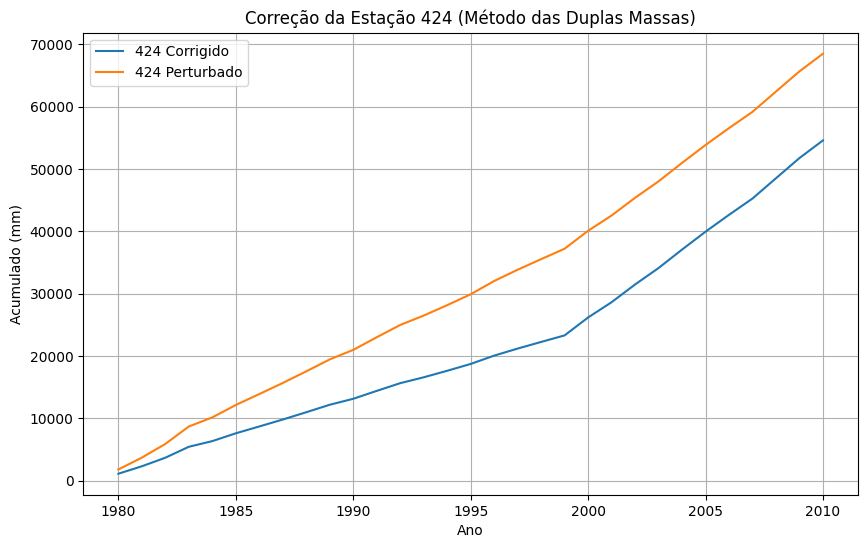

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_anual['year'], p_424_fixed_ac, label='424 Corrigido')
plt.plot(df_anual['year'], p_424_changed_ac, label='424 Perturbado')
plt.title('Correção da Estação 424 (Método das Duplas Massas)')
plt.xlabel('Ano')
plt.ylabel('Acumulado (mm)')
plt.legend()
plt.grid(True)
plt.show()

#**C. Preenchimento de Falhas**

##1. Importação de Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

##2. Importação e Organização de Dados

In [ ]:
# Lista com os códigos das bacias a serem analisadas
bacias = ['424', '422', '426', '428','429']
base1 = "ens"
base2 = "ENS"

# Dicionário para armazenar os DataFrames de cada bacia
dados_bacias = {}

# Loop para importar e preparar os dados de cada bacia
for bacia in bacias:
    url = f"https://raw.githubusercontent.com/hydrologywatersecurity/livro-python-hidrologia/refs/heads/main/CABRA_dataset/CABra_climate_daily_series/{base1}/CABra_{bacia}_climate_{base2}.txt"

    conteudo = requests.get(url).content
    df = pd.read_csv(io.StringIO(conteudo.decode('utf-8', errors='ignore')),
                     skiprows=13,
                     delimiter='\t')

    # Exclui primeira coluna depois do cabeçalho, pois contém unidades
    df = df.iloc[1:].copy()

    # Renomeia colunas
    df.columns = ['Year', 'Month', 'Day', 'p', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'pet_pm','pet_pt', 'pet_hg']

    # Converte colunas para valores numéricos
    for col in ['Year', 'Month', 'Day', 'p', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'pet_pm','pet_pt', 'pet_hg']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Cria coluna de data
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    # Seleciona apenas data e precipitação
    df = df[['date', 'p']]

    # Renomeia a coluna de precipitação para o código da bacia
    df = df.rename(columns={'p': bacia})

    # Armazena o DataFrame no dicionário
    dados_bacias[bacia] = df

# Une os dados de todas as bacias pela coluna 'date'
df_merged = dados_bacias[bacias[0]]
for bacia in bacias[1:]:
    df_merged = pd.merge(df_merged, dados_bacias[bacia], on='date', how='inner')

In [ ]:
# Agrupa precipitações por ano
df_merged['year'] = df_merged['date'].dt.year
df_anual = df_merged.groupby('year')[bacias].sum().reset_index()
df_anual = df_anual[df_anual['year'].between(1980, 2011)].reset_index(drop=True)

# Cria vetores separados
all_1 = df_anual['424'].values.copy()
all_2 = df_anual['422'].values
all_3 = df_anual['426'].values
all_4 = df_anual['429'].values
all_5 = df_anual['428'].values

# Concatena num array para manipulação vetorial
all_y = np.vstack([all_1, all_2, all_3, all_4, all_5]).T  # shape (32, 5)

##3. Simulação de falhas e determinação de correlações entre estações

In [ ]:
# Simulação de falhas em 424 (1990–1997)
all_y_ = all_y.copy()
all_y_[10:18, 0] = np.nan  # remove valores da bacia 424 entre 1990 e 1997

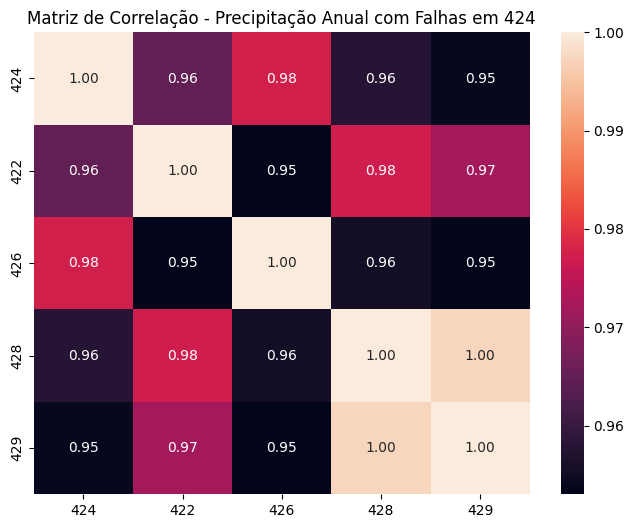

Estação de referência para preencher 424: 426 (r = 0.98)


In [ ]:
# Correlação entre estações
# Cria DataFrame com nomes das bacias
dfy_ = pd.DataFrame(all_y_, columns=bacias)

# Calcula matriz de correlação
correlacao = dfy_.corr()

# Plota heatmap da correlação
plt.figure(figsize=(8, 6))
sns.heatmap(correlacao, annot=True, fmt=".2f")
plt.title("Matriz de Correlação - Precipitação Anual com Falhas em 424")
plt.show()

# Estação com maior correlação com a 424
coefs = correlacao['424'].drop('424')
bacia_ref = coefs.idxmax()
print(f"Estação de referência para preencher 424: {bacia_ref} (r = {coefs.max():.2f})")

##4. Preenchimento de falha de dados segundo a estação de referência

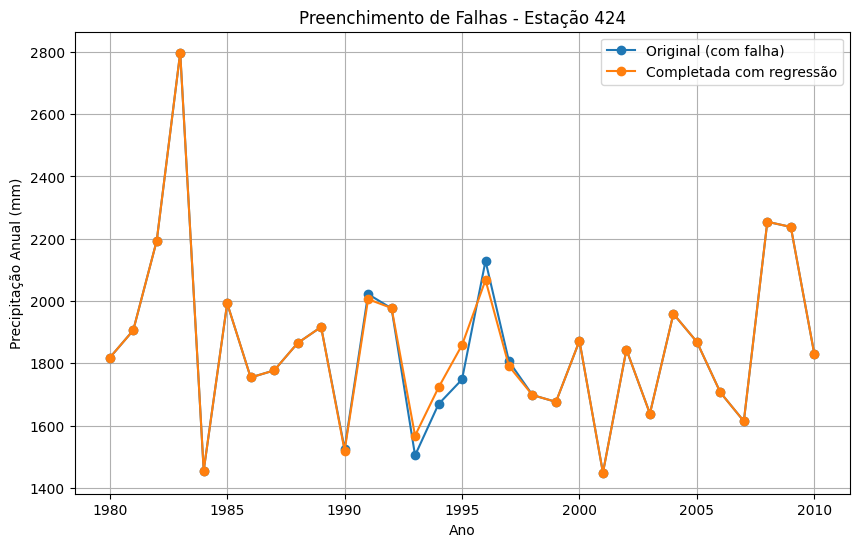

In [ ]:
# Regressão Linear e Previsão

# Usa apenas anos sem falha para treinar (exceto 1990–1997)
X_train = df_anual[bacia_ref].values.copy().reshape(-1, 1)
y_train = df_anual['424'].values.copy()

# Remove os anos com falha para regressão
mask_train = ~np.isnan(all_y_[:, 0])
X_train = X_train[mask_train]
y_train = y_train[mask_train]

# Treina regressão linear
model = LinearRegression().fit(X_train, y_train)

# Prediz os valores para os anos com falha (1990–1997)
X_pred = df_anual.loc[10:17, bacia_ref].values.reshape(-1, 1)
y_pred = model.predict(X_pred)

#--------------------------------------------
# Substitui valores faltantes pela previsão
new_424 = all_y[:, 0].copy()
new_424[10:18] = y_pred

# Plot comparativo
plt.figure(figsize=(10, 6))
plt.plot(df_anual['year'], all_y[:, 0], label='Original (com falha)', marker='o')
plt.plot(df_anual['year'], new_424, label='Completada com regressão', marker='o')
plt.title('Preenchimento de Falhas - Estação 424')
plt.xlabel('Ano')
plt.ylabel('Precipitação Anual (mm)')
plt.legend()
plt.grid(True)
plt.show()